In [2]:
import csv
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# 1 Data Preperation

In [3]:

netflix = pd.DataFrame()
netflix = pd.read_csv('netflix_titles.csv')

# 1.1. Check duplicates values in the dataset.
netflix = netflix.drop_duplicates()

# 1.2. Find the missing rows in each column.
# 1.3. Remove the NaN values from the dataset.
netflix = netflix.dropna()

# 1.4. change the `date added' values to the only year. And rename the column: 'added year'.
netflix['date_added'] = netflix['date_added'].apply(lambda x: pd.Timestamp(x).strftime('%Y'))
netflix = netflix.rename(columns={"date_added": "added_year"})
netflix

,show_id,type,title,director,cast,country,added_year,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
6,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2017,2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f..."
7,80164077,Movie,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017,2017,TV-MA,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...
9,70304990,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden",2017,2014,R,90 min,"Action & Adventure, Thrillers",A struggling couple can't believe their luck w...
...,...,...,...,...,...,...,...,...,...,...,...,...
6142,80063224,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,2019,2019,TV-PG,7 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
6158,80164216,TV Show,Miraculous: Tales of Ladybug & Cat Noir,Thomas Astruc,"Cristina Vee, Bryce Papenbrook, Keith Silverst...","France, South Korea, Japan",2019,2018,TV-Y7,4 Seasons,"Kids' TV, TV Action & Adventure","When Paris is in peril, Marinette becomes Lady..."
6167,80115328,TV Show,Sacred Games,"Vikramaditya Motwane, Anurag Kashyap","Saif Ali Khan, Nawazuddin Siddiqui, Radhika Ap...","India, United States",2019,2019,TV-MA,2 Seasons,"Crime TV Shows, International TV Shows, TV Dramas",A link in their pasts leads an honest cop to a...
6182,80176842,TV Show,Men on a Mission,Jung-ah Im,"Ho-dong Kang, Soo-geun Lee, Sang-min Lee, Youn...",South Korea,2019,2019,TV-14,4 Seasons,"International TV Shows, Korean TV Shows, Stand...",Male celebs play make-believe as high schooler...


In [4]:
# 1.5 1.6 and 1.7
net_copy = netflix.copy()
net_copy = net_copy[['show_id','type','cast']]

lst = []
for _, row in net_copy.iterrows():
    actors_list = row['cast'].split(",")
    show_id = row['show_id']
    category = row['type']
    for actor in actors_list:
        lst.append([actor,show_id,category])

cols = ['actor_name','show_id','type']
netflix_copy = pd.DataFrame(lst,columns = cols)
netflix_copy

,actor_name,show_id,type
0,Alan Marriott,81145628,Movie
1,Andrew Toth,81145628,Movie
2,Brian Dobson,81145628,Movie
3,Cole Howard,81145628,Movie
4,Jennifer Cameron,81145628,Movie
...,...,...,...
29384,Cengiz Bozkurt,80126599,TV Show
29385,Osman Sonant,80126599,TV Show
29386,Köksal Engür,80126599,TV Show
29387,Ege Tanman,80126599,TV Show


# 2 Data Discovering

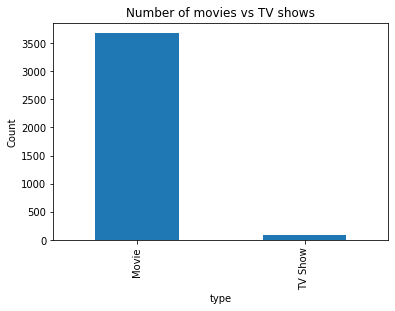

In [6]:
# 2.1. Plot the number of movies vs TV shows.

type_grouped = netflix.groupby('type').size()
type_grouped.plot(kind='bar')
plt.title("Number of movies vs TV shows")
plt.ylabel('Count')
plt.show()

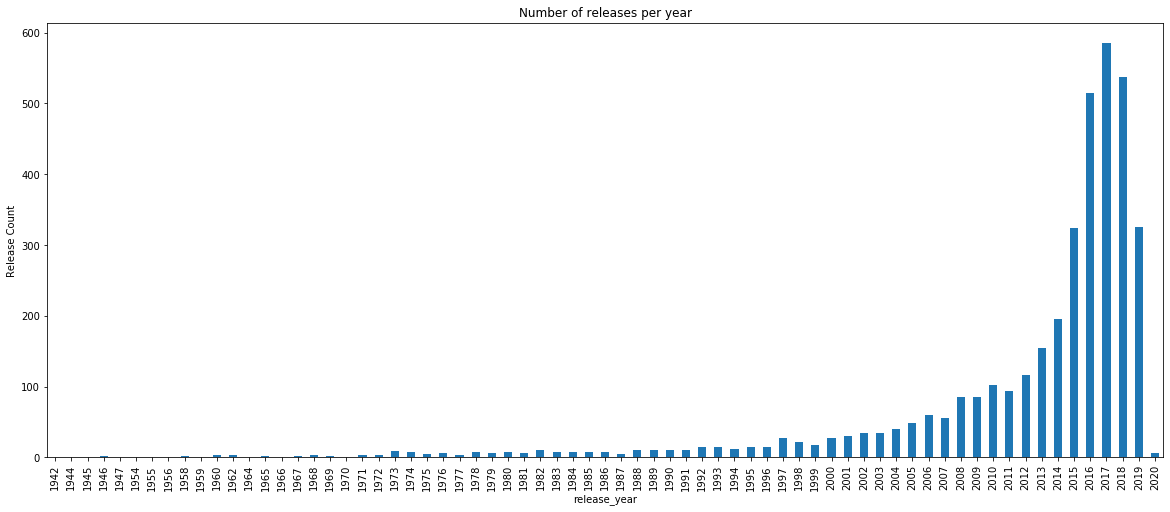

In [7]:
# 2.2. Plot the number of releases per year. Give an interpretation.

plt.figure(figsize=(20,8))
year_grouped = netflix.groupby('release_year').size()
year_grouped.plot(kind='bar')
plt.title("Number of releases per year")
plt.ylabel('Release Count')
plt.show()

Looking at the data we can infer that the number of releases per year gradually increases till year 2000 and further increases exponentially till 2017 reaching the peak. Then the it drops till 2020.

In [9]:
# 2.3. What is the highest year in adding new shows?

year_grouped = netflix[netflix.type == 'TV Show'].groupby('added_year').size()
print(year_grouped)

added_year
2013     1
2015     3
2016     7
2017    27
2018    18
2019    39
2020     1
dtype: int64


Highest number of shows are added in the year of 2019

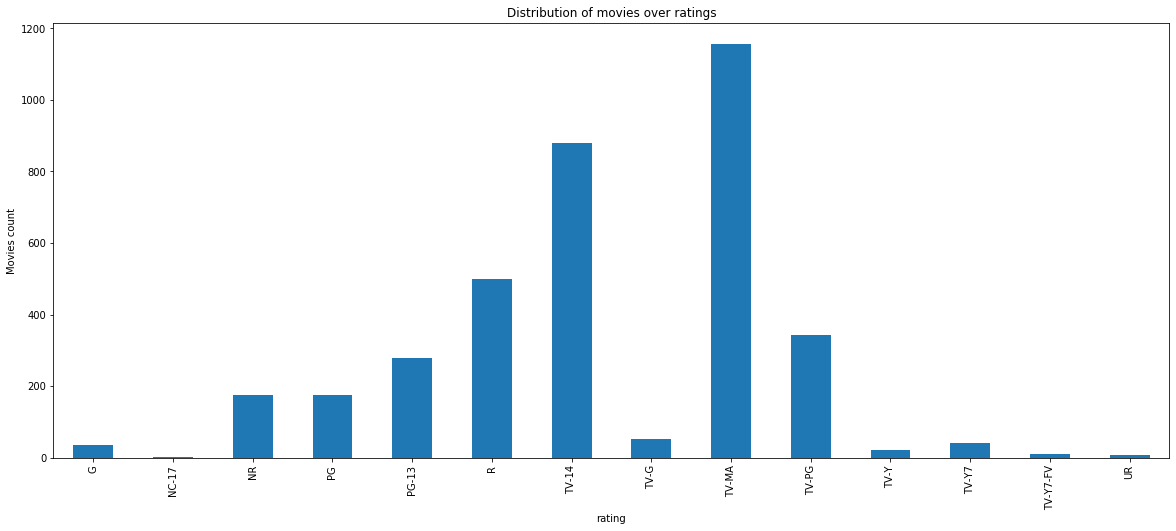

In [10]:
# 2.4. What are the types of ratings for the movies? Plot for each rating the number of movies.

ratings_grouped = netflix[netflix.type == 'Movie'].groupby('rating').size()
plt.figure(figsize=(20,8))
ratings_grouped.plot(kind='bar')
plt.title("Distribution of movies over ratings")
plt.ylabel('Movies count')
plt.show()

# 3 Social Network analysis

In [12]:
# 3.1 Create a co-acting network

Co_actor_net = nx.Graph()

for _, row in netflix.iterrows():
    actors_list = row['cast'].split(",")
    count = len(actors_list)
    if(count >1):
        for i in range(count):
            for j in range(i+1,count):
                Co_actor_net.add_edge(actors_list[i],actors_list[j])

print(nx.info(Co_actor_net))

Name: 
Type: Graph
Number of nodes: 19797
Number of edges: 125395
Average degree:  12.6681


In [13]:
# 3.2 Compute the betweenness centrality, degree centrality , and close-ness centrality for each node.

bet_cent_dict=nx.betweenness_centrality(Co_actor_net)

In [16]:
deg_cent_dict=nx.degree_centrality(Co_actor_net)

In [17]:
clos_cent_dict=nx.closeness_centrality(Co_actor_net)

In [18]:
# 3.3. For each centrality measure, find the actor with the highest value.

max_bet_cent_actor = max(bet_cent_dict, key=bet_cent_dict.get)
max_deg_cent_actor = max(deg_cent_dict, key=deg_cent_dict.get)
max_clos_cent_actor = max(clos_cent_dict, key=clos_cent_dict.get)

print("highest betweenness centrality actor : ",max_bet_cent_actor)
print("highest degree centrality actor : ",max_deg_cent_actor)
print("highest closeness centrality actor : ",max_clos_cent_actor)

highest betweenness centrality actor :   Anupam Kher
highest degree centrality actor :   Anupam Kher
highest closeness centrality actor :   Alfred Molina


In [22]:
# 3.4. Compute the average length of the shortest path and the average clustering coefficient.

#avg_shortest_path_length = nx.average_shortest_path_length(Co_actor_net)
avg_clustering_coeff = nx.average_clustering(Co_actor_net)

#print("average length of the shortest path ",avg_shortest_path_length)
print("Average clustering coefficient ",avg_clustering_coeff)

Average clustering coefficient  0.8651292596560557


Not able to calculate  average length of shortest path since the graph is not connected

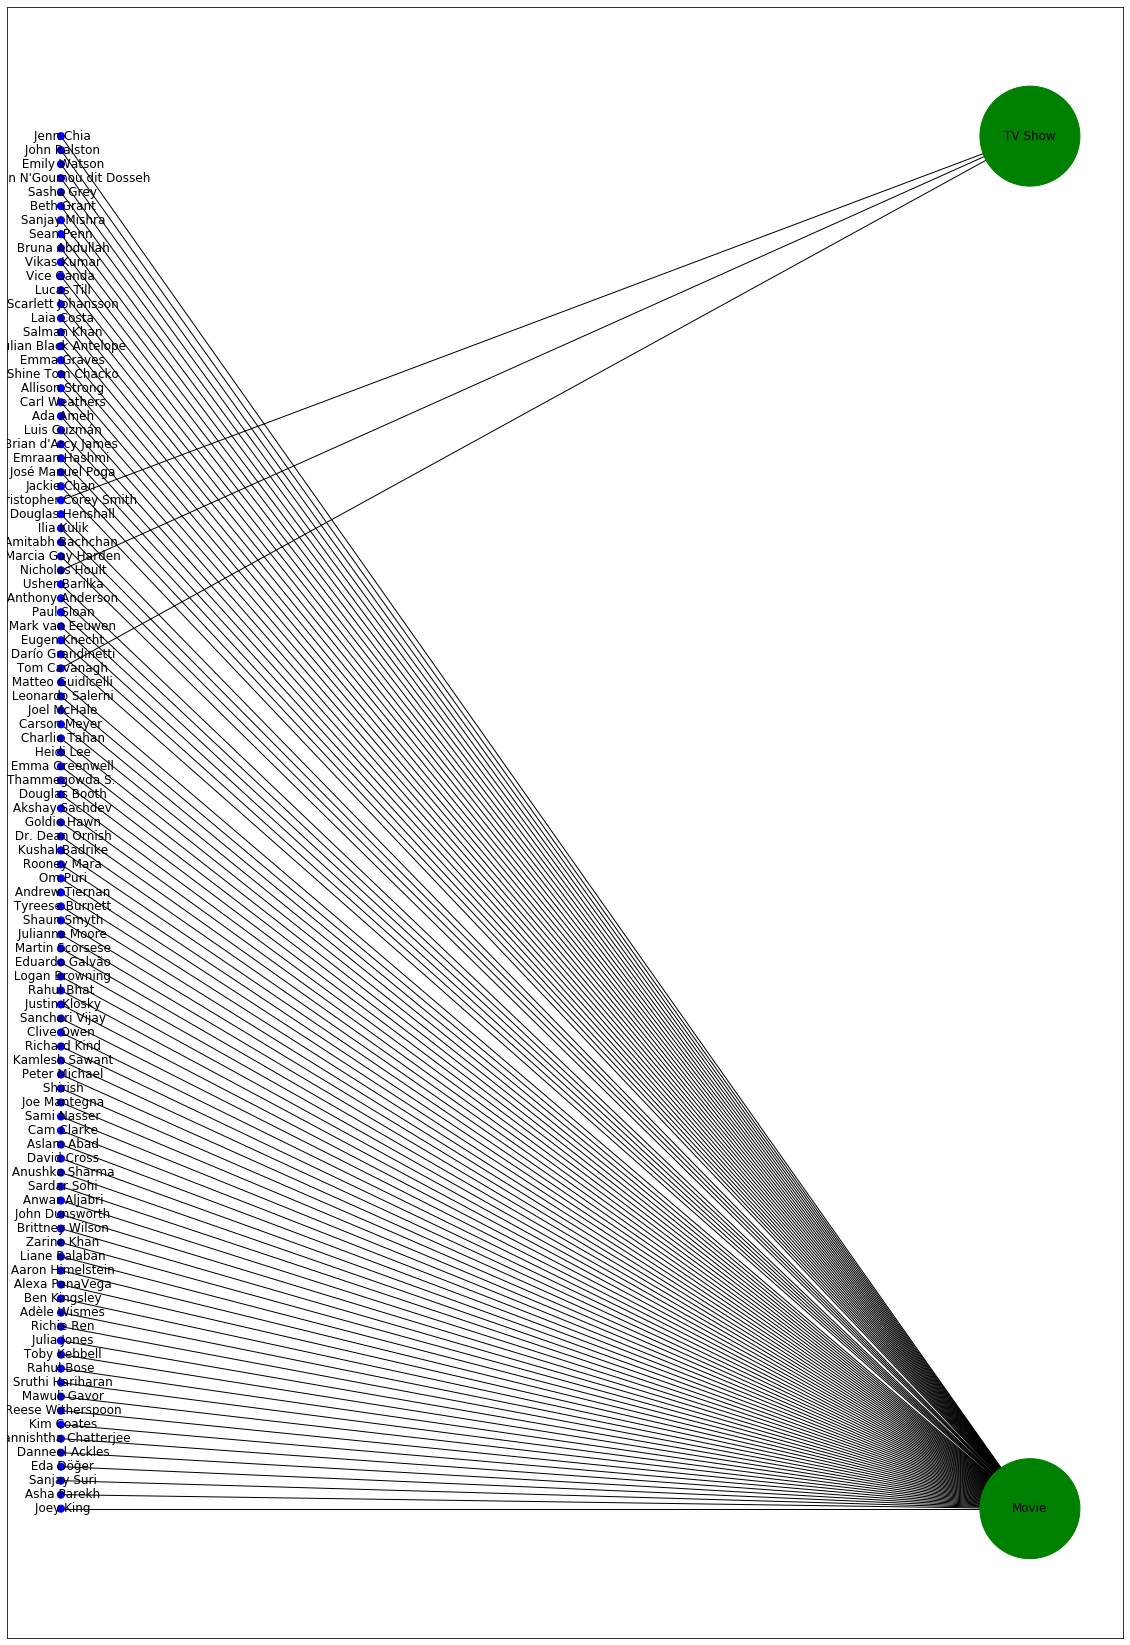

In [26]:
#3.5 Shuffle your data and take the first 100 rows and plot two modes network

df = netflix_copy.sample(n=100)
actors_list = df['actor_name'].tolist()
type_list = df['type'].tolist()
combo = list(zip(actors_list,type_list))

two_mode_net = nx.Graph()
two_mode_net.add_edges_from(combo)
pos = nx.bipartite_layout(two_mode_net,actors_list)
plt.figure(figsize=(20,30))

node_list = list(two_mode_net.nodes())
node_color = ['g' if( node == 'Movie' or node == 'TV Show') else 'b' for node in node_list ]
node_size =  [10000 if( node == 'Movie' or node == 'TV Show') else 50 for node in node_list]

nx.draw_networkx(two_mode_net,pos=pos,node_color=node_color,node_size=node_size, with_labels=True)